In [1]:
# note Grakel does not seem to support Python >=3.10, Python 3.9 works fine
# you are free to remove imports that are not useful for you


from grakel.datasets import fetch_dataset
from grakel.kernels import WeisfeilerLehman, VertexHistogram
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.decomposition import KernelPCA # to check your own implementation
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
from typing import *

The MUTAG dataset consists of 188 chemical compounds divided into two
classes according to their mutagenic effect on a bacterium.

The chemical data was obtained form http://cdb.ics.uci.edu and converted
to graphs, where vertices represent atoms and edges represent chemical
bonds. Explicit hydrogen atoms have been removed and vertices are labeled
by atom type and edges by bond type (single, double, triple or aromatic).
Chemical data was processed using the Chemistry Development Kit (v1.4).

ENZYMES is a dataset of protein tertiary structures obtained from (Borgwardt et al., 2005)
consisting of 600 enzymes from the BRENDA enzyme database (Schomburg et al., 2004).
In this case the task is to correctly assign each enzyme to one of the 6 EC top-level
classes.

NCI1 and NCI109 represent two balanced subsets of datasets of chemical compounds screened
for activity against non-small cell lung cancer and ovarian cancer cell lines respectively
(Wale and Karypis (2006) and http://pubchem.ncbi.nlm.nih.gov).

More datasets here https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets


The grakel training datasets are a list of graphs, where for each graph, we have its corresponding adjacency set (aka the set of pairs of node that are connected to each other), a dictionary that maps each node integer to its label value (which also happens to be an int), and another dictionary that maps edges to labels.

In [3]:
AdjacencySet = Set[Tuple[int, int]] # Set of adjacent node pairs
Edge = Tuple[int, int] # Type of a graph edge
dataset_MUT = fetch_dataset("MUTAG", verbose=False)

G_MUT: List[Tuple[AdjacencySet, Dict[int, int], Dict[Edge, int]]] = dataset_MUT.data
y_MUT: np.ndarray = dataset_MUT.target

dataset_ENZ = fetch_dataset("ENZYMES", verbose=False)
G_ENZ: List[Tuple[AdjacencySet, Dict[int, int], Dict[Edge, int]]] = dataset_ENZ.data
y_ENZ: np.ndarray = dataset_ENZ.target

dataset_NCI = fetch_dataset("NCI1", verbose=False)
G_NCI: List[Tuple[AdjacencySet, Dict[int, int], Dict[Edge, int]]] = dataset_NCI.data
y_NCI: np.ndarray = dataset_NCI.target

In [4]:
print(type(G_MUT[0]))
for graph_metadata in (G_MUT[0]):
    print(f"{type(graph_metadata)=}")
    print(graph_metadata)

<class 'list'>
type(graph)=<class 'set'>
{(3, 4), (4, 3), (5, 4), (12, 13), (5, 7), (14, 13), (8, 9), (9, 8), (9, 14), (17, 15), (10, 9), (1, 6), (13, 14), (6, 5), (15, 17), (4, 5), (14, 9), (5, 6), (9, 10), (1, 2), (10, 11), (2, 1), (11, 10), (6, 1), (15, 13), (15, 16), (13, 15), (16, 15), (3, 2), (12, 11), (4, 10), (8, 7), (10, 4), (2, 3), (11, 12), (13, 12), (7, 5), (7, 8)}
type(graph)=<class 'dict'>
{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 1, 16: 2, 17: 2}
type(graph)=<class 'dict'>
{(2, 1): 0, (1, 2): 0, (3, 2): 0, (2, 3): 0, (4, 3): 0, (3, 4): 0, (5, 4): 0, (4, 5): 0, (6, 5): 0, (5, 6): 0, (6, 1): 0, (1, 6): 0, (7, 5): 0, (5, 7): 0, (8, 7): 0, (7, 8): 0, (9, 8): 0, (8, 9): 0, (10, 9): 0, (9, 10): 0, (10, 4): 0, (4, 10): 0, (11, 10): 0, (10, 11): 0, (12, 11): 0, (11, 12): 0, (13, 12): 0, (12, 13): 0, (14, 13): 0, (13, 14): 0, (14, 9): 0, (9, 14): 0, (15, 13): 1, (13, 15): 1, (16, 15): 2, (15, 16): 2, (17, 15): 1, (15, 17): 1}


In [45]:
y_MUT

array([ 1, -1, -1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,
        1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1, -1,  1, -1, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,
        1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,
       -1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,
        1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1,  1,
       -1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1, -1, -1,  1,
       -1])

# 1.1. Weisfeiler-Lehman subtree complexity
See report.

# 1.2. Compute the kernels
The arbitrary number of iterations $H$ that we whose is 10, so that it coincides with the question 1.4..


In [7]:
weis_leh = WeisfeilerLehman(n_iter=10, base_graph_kernel=VertexHistogram)
K_MUT: np.ndarray = weis_leh.fit_transform(G_MUT)
K_ENZ: np.ndarray = weis_leh.fit_transform(G_ENZ)
K_NCI: np.ndarray = weis_leh.fit_transform(G_NCI)

In [9]:
for kernel in (K_MUT, K_ENZ, K_NCI):
    print(f"{kernel.shape=}")
    print(kernel)

kernel.shape=(188, 188)
[[507 210 206 ... 189 473 289]
 [210 263 145 ... 126 260 181]
 [206 145 263 ... 129 256 186]
 ...
 [189 126 129 ... 228 231 179]
 [473 260 256 ... 231 859 361]
 [289 181 186 ... 179 361 396]]
kernel.shape=(600, 600)
[[1279.  502.  585. ...  973.  998.  911.]
 [ 502.  569.  362. ...  591.  615.  565.]
 [ 585.  362.  791. ...  587.  678.  617.]
 ...
 [ 973.  591.  587. ... 2439. 1417. 1333.]
 [ 998.  615.  678. ... 1417. 1953. 1423.]
 [ 911.  565.  617. ... 1333. 1423. 1834.]]
kernel.shape=(4110, 4110)
[[ 467  267  333 ...  455  397  424]
 [ 267  718  288 ...  755  671  652]
 [ 333  288  935 ...  482  429  446]
 ...
 [ 455  755  482 ... 1929 1231 1216]
 [ 397  671  429 ... 1231 1402 1020]
 [ 424  652  446 ... 1216 1020 1673]]


# 1.4. Explicit embedding versus kernel
Computing the rank of the WL subtree kernel matrix for all three datasets, with H=10 iterations.

In [49]:
from numpy.linalg import matrix_rank
# NB : if n_iter has been changed from 10 in the previous cell, the kernel matrices need to be recomputed with n_iter=10 here !
print("Dataset\tRank\t# samples")
print("\t".join(("MUTAG", str(matrix_rank(K_MUT)),  str(len(G_MUT)))))
print("\t".join(("ENZYMES", str(matrix_rank(K_ENZ)),  str(len(G_ENZ)))))
print("\t".join(("NCI1", str(matrix_rank(K_NCI)),  str(len(G_NCI)))))

Dataset	Rank	# samples
MUTAG	175	188
ENZYMES	595	600
NCI1	4002	4110


# 2.1. Kernel centralization

In [12]:
# Centering the kernel
ONE = np.ones((len(K_MUT),len(K_MUT)))/len(K_MUT)
K_MUT_C = K_MUT - ONE@K_MUT - K_MUT@ONE + ONE@K_MUT@ONE

ONE = np.ones((len(K_ENZ),len(K_ENZ)))/len(K_ENZ)
K_ENZ_C = K_ENZ - ONE@K_ENZ - K_ENZ@ONE + ONE@K_ENZ@ONE

ONE = np.ones((len(K_NCI),len(K_NCI)))/len(K_NCI)
K_NCI_C = K_NCI - ONE@K_NCI - K_NCI@ONE + ONE@K_NCI@ONE

# 2.2. kernel-PCA implementation

In [42]:
def kpca(K,n_comp):
    lambdas,alpha = np.linalg.eig(K)
    alpha = alpha.T
    alpha = np.array([v/np.linalg.norm(v) for v in alpha])   # normalization of the eigenvectors

    tab = lambdas > 1e-11
    new_alpha = []
    for i in range(len(alpha)):
        if tab[i] :
            new_alpha.append(alpha[i])   # only consider the non-zero eigenvalues of K

    alpha = np.array(new_alpha)

    lambdas = np.extract(lambdas > 1e-11, lambdas)


    dico = {}
    for i in range(len(lambdas)):
        dico[lambdas[i]] = alpha[i]   # map non-zero eigenvalues to their normalized eigenvector

    new_dico = {}
    for k in sorted(dico.keys(),reverse=True):   # consider the eigenvalues in decreasing order
        new_dico[k] = dico[k]


    K_TF = []
    for j in range(len(K)):
        new_coord = []   # compute the coordinates of the points of the dataset in the embedding defined by the n_comp PC's
        for k in range(n_comp):
            somme = 0
            for i in range(len(alpha[k])):
                somme += alpha[k][i].real*K[i][j]
            new_coord.append(somme)
        K_TF.append(np.array(new_coord))

    K_TF = np.array(K_TF)

    return K_TF

# 2.3. kernel-PCA visualization

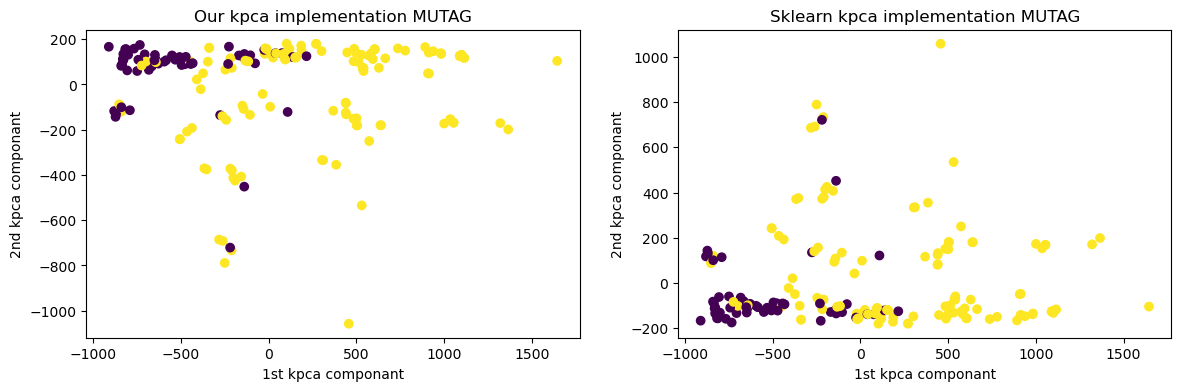

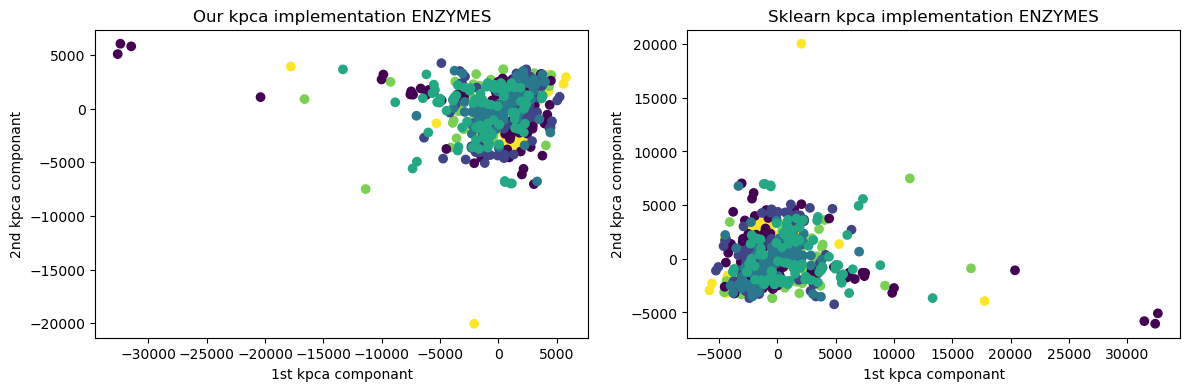

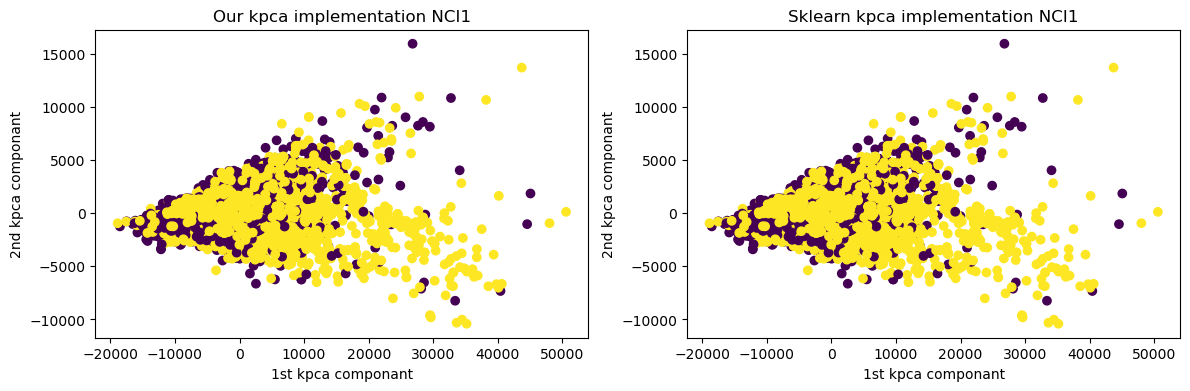

In [43]:
# This cell may require nearly 2 minutes to be executed because NCI1 dataset is big

K_MUT_TF = kpca(K_MUT_C,2)
K_ENZ_TF = kpca(K_ENZ_C,2)
K_NCI_TF = kpca(K_NCI_C,2)


def visualize(K_C, K_TF, y, title):
    tf = KernelPCA(n_components=2,kernel='linear')
    X_tf = tf.fit_transform(K_C)
    fig, (my_kpca_ax, kpca_ax) = plt.subplots(
        ncols=2, figsize=(14, 4)
    )
    my_kpca_ax.scatter(K_TF[:,0],K_TF[:,1],c=y)
    my_kpca_ax.set_xlabel("1st kPCA component")
    my_kpca_ax.set_ylabel("2nd kPCA component")
    my_kpca_ax.set_title("Our kPCA implementation " + title)
    

    kpca_ax.scatter(X_tf[:,0],X_tf[:,1],c=y)
    kpca_ax.set_xlabel("1st kPCA component")
    kpca_ax.set_ylabel("2nd kPCA component")
    kpca_ax.set_title("Sklearn's kPCA implementation " + title)
    savepath = "kpca-{}.pdf".format(title)
    plt.savefig(savepath)

visualize(K_MUT_C,K_MUT_TF,y_MUT,"MUTAG")
visualize(K_ENZ_C,K_ENZ_TF,y_ENZ,"ENZYMES")
visualize(K_NCI_C,K_NCI_TF,y_NCI,"NCI1")



# 2.4. Distance

In [46]:
def compute_dist(K):
    dist = []
    for i in range(len(K)):
        for j in range(i+1,len(K)):
            dist.append(np.sqrt(K[i][i] + K[j][j] - 2*K[i][j]))
    return dist

dist_MUT = compute_dist(K_MUT)
dist_ENZ = compute_dist(K_ENZ)
dist_NCI = compute_dist(K_NCI)

for dataset_name, dist_matrix in (("MUTAG", dist_MUT), ("ENZYMES", dist_ENZ), ("NCI1", dist_NCI)):
    print(f"Mean pairwise distance for the {dataset_name} graph")
    print(np.mean(dist_matrix))


Mean pairwise distance for the MUTAG graph
22.7449724619337
Mean pairwise distance for the ENZYMES graph
35.58220470465758
Mean pairwise distance for the NCI1 graph
33.46885291094932


# 2.5. tSNE
See report.

# 2.6. Comparison

In [ ]:
def compare_kpca_tsne(K_C,y,title):
    tf1 = KernelPCA(n_components=2,kernel='linear')
    tf2 = TSNE()   # by default, tSNE uses Euclidean distance as metric => ok since our distance corresponds to the Euclidean distance in the embedding space
    X_tf_kpca = tf1.fit_transform(K_C)
    X_tf_tsne = tf2.fit_transform(K_C)
    fig, (kpca_ax, tsne_ax) = plt.subplots(
        ncols=2, figsize=(14, 4)
    )
    kpca_ax.scatter(X_tf_kpca[:,0],X_tf_kpca[:,1],c=y)
    kpca_ax.set_xlabel("1st kPCA component")
    kpca_ax.set_ylabel("2nd kPCA component")
    kpca_ax.set_title("Visualisation with kPCA " + title)

    tsne_ax.scatter(X_tf_tsne[:,0],X_tf_tsne[:,1],c=y)
    tsne_ax.set_xlabel("1st dimension")
    tsne_ax.set_ylabel("2nd dimension")
    tsne_ax.set_title("Visualisation with tSNE " + title)
    
    savepath = "tsne-{}.pdf".format(title)
    plt.savefig(savepath)

compare_kpca_tsne(K_MUT_C,y_MUT,"MUTAG")
compare_kpca_tsne(K_ENZ_C,y_ENZ,"ENZYMES")
compare_kpca_tsne(K_NCI_C,y_NCI,"NCI1")

In [56]:
labels_MUT = {item:list(y_MUT).count(item) for item in y_MUT}
print("Number of occurrences of the labels in MUTAG : " + str(labels_MUT))
labels_ENZ = {item:list(y_ENZ).count(item) for item in y_ENZ}
print("Number of occurrences of the labels in ENZYMES : " + str(labels_ENZ))
labels_NCI = {item:list(y_NCI).count(item) for item in y_MUT}
print("Number of occurrences of the labels in MUTAG : " + str(labels_MUT))

Number of occurences of the labels in MUTAG : {1: 125, -1: 63}


# 3.1. A simple baseline
The best constant model will learn what's the mode of the training dataset

In [47]:
from collections import Counter
# Ideally, the constant model should be "fitted" to the training set and learn the mode of the training set, not that of the test set.
for dataset_name, target_dataset in (("MUTAG", y_MUT), ("ENZYMES", y_ENZ), ("NCI1", y_NCI)):
    target_counter = Counter(target_dataset)
    print(dataset_name, "\t", target_counter, '\tAccuracy of constant model\t', round(max(target_counter.values())/sum(target_counter.values()), 3))

MUTAG 	 Counter({1: 125, -1: 63}) 	Accuracy of constant model	 0.665
ENZYMES 	 Counter({6: 100, 5: 100, 1: 100, 2: 100, 3: 100, 4: 100}) 	Accuracy of constant model	 0.167
NCI1 	 Counter({1: 2057, 0: 2053}) 	Accuracy of constant model	 0.5


# 3.2. Support Vector Machines

In [50]:
def model_SVC(dataset,y,c,h) -> float:
    WL = WeisfeilerLehman(n_iter=h, base_graph_kernel=VertexHistogram) 
    X = WL.fit_transform(dataset)

    # Split dataset into 80/20 training/testing partitions
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = SVC(C=c)
    model.fit(X_train,y_train)

    accuracy = model.score(X_test,y_test)
    return accuracy

print("Dataset\tAccuracy")
print("MUTAG\t", model_SVC(G_MUT,y_MUT,1e2,3))
print("ENZYMES\t", model_SVC(G_ENZ,y_ENZ,1e2,3))
print("NCI1\t", model_SVC(G_NCI,y_NCI,1e2,3))

Dataset	Accuracy
MUTAG	 0.868421052631579
ENZYMES	 0.43333333333333335
NCI1	 0.7384428223844283


# 3.3. Select hyper-parameters

In [51]:
# 2min30 to be executed
Cs = [10**exponent for exponent in range(-5, 5)]
Hs = range(1, 11)
def find_best_params(data,y):
    cv_scores = []
    for c in Cs:
        for h in Hs:
            WL = WeisfeilerLehman(n_iter=h, base_graph_kernel=VertexHistogram) 
            X = WL.fit_transform(data)
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = SVC(C=c)

            scores = cross_val_score(model,X_train,y_train,cv=10,scoring='accuracy')
            cv_scores.append((np.mean(scores),(c,h)))
    return max(cv_scores, key=lambda x: x[0])

scores_MUT = find_best_params(G_MUT,y_MUT)
scores_ENZ = find_best_params(G_ENZ,y_ENZ)
print("Dataset\tBest H\tBest C")
print("MUT\t", str(scores_MUT[1][1]), "\t", str(scores_MUT[1][0]))
print("ENZ\t", str(scores_ENZ[1][1]), "\t", str(scores_ENZ[1][0]))

Dataset	Best H	Best C
MUT	 1 	 10.0
ENZ	 10 	 1000.0


In [ ]:
# This cell takes too long to evaluate
Cs = [10**exponent for exponent in range(-2, 2)]
Hs = range(3, 6)
scores_NCI = find_best_params(G_NCI,y_NCI)

print("Dataset\tBest H\tBest C")
print("NCI\t", str(scores_NCI[1][1]), "\t", str(scores_NCI[1][0]))